In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from lightgbm import LGBMClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
pd.set_option('display.max_rows', 500)

In [2]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
    
def cm_single(y_test, y_pred, fontsize=14):
    
    labels = ["".join("c" + str(i[0])) for i in pd.DataFrame(y_test).value_counts().index]
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    fig = plt.figure(figsize=(6,4))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    heatmap.set_title("Confusion Matrix for Binary Label" )
    plt.show()
        

def cm_plot(y_test, y_pred, nrow=3, ncol=2):
    
    labels = ["".join("c" + str(i[0])) for i in pd.DataFrame(y_test).value_counts().index]
    cm = multilabel_confusion_matrix(y_test, y_pred)
    if nrow == 1: 
        figsize = (8,4)
    else:
        figsize = (12,7)
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
    if nrow == 3:
        fig.delaxes(ax[2,1])
    fig.tight_layout()
    plt.show()
    
def pr_auc(X_test, y_test, n_classes):
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 7))
    
    # Precision-Recall Curve
    y_score = model.predict_proba(X_test)
    y_test = label_binarize(y_test, classes=[*range(n_classes)])
    precision = dict()
    recall = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
        ax[0].plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    no_skill = len(y[y==1]) / len(y)
    ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].legend(loc="best")
    ax[0].set_title("precision vs. recall curve")

    # ROC curve
    fpr = dict()
    tpr = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        ax[1].plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
    ax[1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    ax[1].set_xlabel("false positive rate")
    ax[1].set_ylabel("true positive rate")
    ax[1].legend(loc="best")
    ax[1].set_title("ROC curve")
    
    fig.tight_layout()
    
def class_count(y_test, y_pred):
    true = pd.DataFrame(y_test.value_counts())
    pred = pd.DataFrame(np.unique(y_pred, return_counts=True)[1], columns=['pred_counts'])
    final = pd.concat([true, pred], axis=1)
    display(final)


In [3]:
# Import transformed data
data_treated = pd.read_csv("../data/treated_transformed_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
n_classes = len(set(data_treated.target))

In [4]:
# Import transformed data
data_treated = pd.read_csv("../data/treated_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
n_classes = len(set(data_treated.target))

In [5]:
data_treated.target.unique()

array([0, 4, 3, 1, 2], dtype=int64)

# Baseline Model

Best model obtained amongst: 
- Weighted logistic regression
- Random Forest Classifier
- Support Vector Machine (Linear, RBF Kernel) 

Data Transformations techniques: 
- Log transformation for heavily skewed data + sqrt transformation for moderately skewed data
- Outlier removal for healthy target class using IQR method 
- Missing data removal due to low proportion data
- SMOTE sampling for minority class

Other techniques tried but not used: 
- variance threshold feature selection
- ANOVA feature selection
- PCA

In [6]:
X, y = data_treated.iloc[:,:-1], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=123)

In [8]:
# Best Model 
# Perform transformation + outlier removed 
X_otrain, y_otrain = SMOTE().fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)

# filename = '../models/lgbm_baselinemodel.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))

,target,pred_counts
0,2951,2982
1,30,16
2,18,18
3,16,4
4,8,3


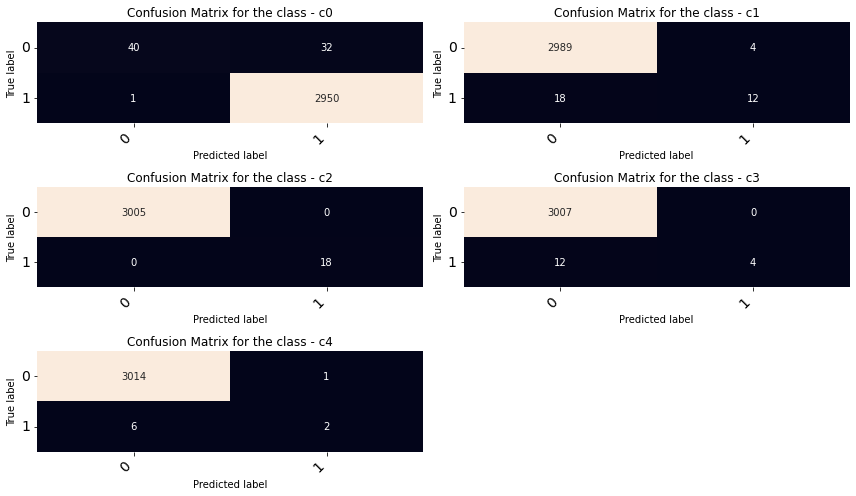

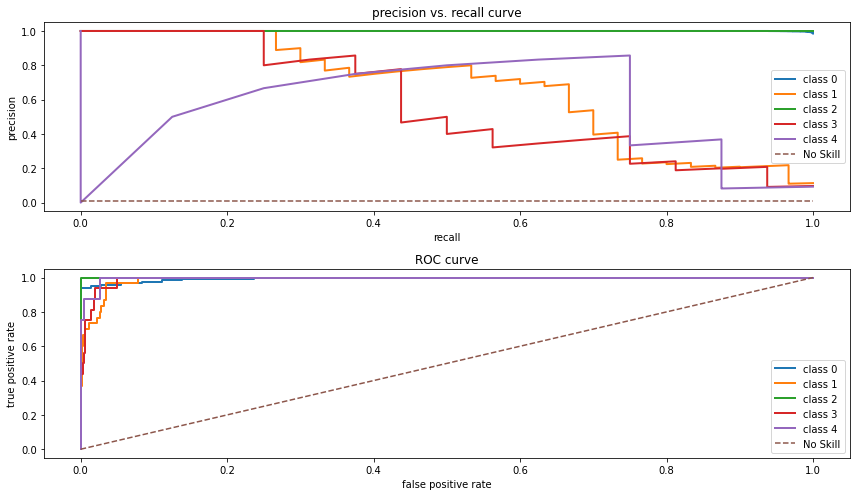

In [9]:
# Plots
filename = '../models/lgbm_baselinemodel.sav'
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
class_count(y_test, y_pred)
cm_plot(y_test, y_pred)
pr_auc(X_test, y_test, n_classes)

In [10]:
labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========\n".format(label))
    
    precision = precision_score(y_test, y_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, y_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, y_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    
    print("\n")

===========Precision, Recall and F1 Score for c0===========

Precision: 0.9893
Recall: 0.9997
F1 score: 0.9944


===========Precision, Recall and F1 Score for c1===========

Precision: 0.7500
Recall: 0.4000
F1 score: 0.5217


===========Precision, Recall and F1 Score for c2===========

Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000


===========Precision, Recall and F1 Score for c3===========

Precision: 1.0000
Recall: 0.2500
F1 score: 0.4000


===========Precision, Recall and F1 Score for c4===========

Precision: 0.6667
Recall: 0.2500
F1 score: 0.3636




# Dual-stage Modelling

- Stage 1: One-Class SVM; Stage 2: kNN

Interpretation: One-class SVM does not identify anomalies well, yield lots of FP and FN

- Stage 1: One-Class PCA; Stage 2: kNN

Reference: https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html

- Stage 1: LGBM; Stage 2: kNN

## One-Class SVM 

In [114]:
temp = data_treated.loc[X_train.index,:]
oc_train = temp.loc[temp['target']==0,temp.columns != "target"]

In [173]:
y_test[y_test==0].shape

(2951,)

In [261]:
clf = OneClassSVM(kernel='poly', gamma=0.001, nu=0.03).fit(oc_train)
# filename = '../models/ocsvm_v1.sav'
# pickle.dump(clf, open(filename, 'wb'))
# Tuned nu between 0.01-0.05, best obtained is 0.03

In [262]:
filename = '../models/ocsvm_v1.sav'
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
# Note: Values corresponding to -1 are outliers

In [263]:
oc_test = y_test.copy()
oc_test[oc_test!=0] = 1

In [264]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([2941,   82], dtype=int64))

In [265]:
np.unique(oc_test, return_counts=True)

(array([0, 1], dtype=int64), array([2951,   72], dtype=int64))

In [266]:
print(accuracy_score(oc_test, y_pred)*100)
print(confusion_matrix(oc_test, y_pred))
class_count(oc_test, y_pred)

94.90572279192855
[[2869   82]
 [  72    0]]


,target,pred_counts
0,2951,2941
1,72,82


## PCA-based anomaly detection

In [268]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [310]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

In [270]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

In [327]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)

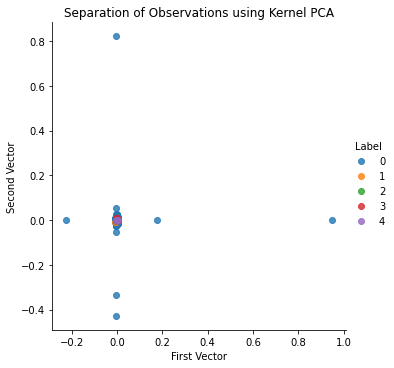

In [276]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 110
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 123
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

### Sparse and Kernel PCA

c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\decomposition\_kernel_pca.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=8.22124e-20): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)


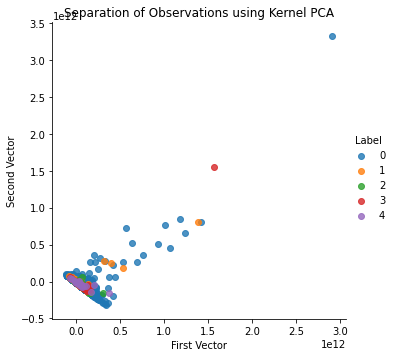

In [282]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 110
kernel = 'poly'
gamma = None
fit_inverse_transform = True
random_state = 123
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

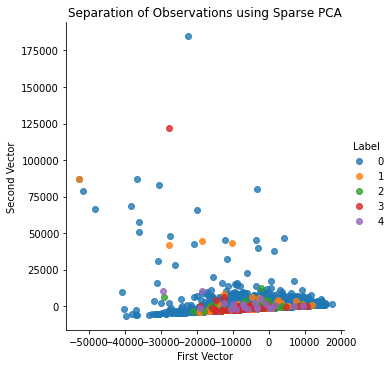

In [280]:
# Sparse PCA
from sklearn.decomposition import SparsePCA

n_components = 110
alpha = 0.0001
random_state = 123
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

### Normal PCA

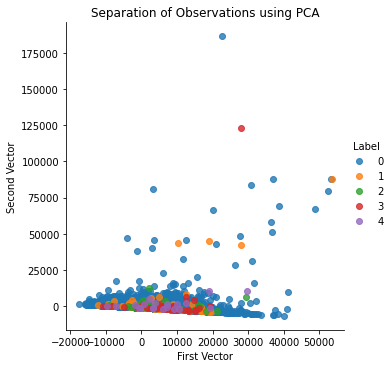

In [377]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 10
whiten = False
random_state = 123

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)
# filename = '../models/pca_v1.sav'
# pickle.dump(pca, open(filename, 'wb'))

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

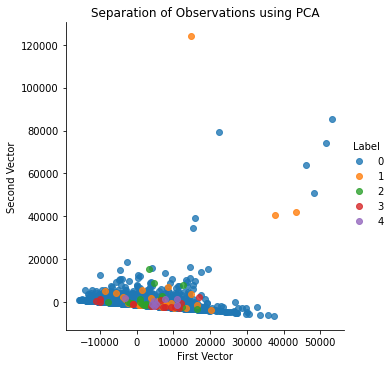

In [378]:
# Test
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)

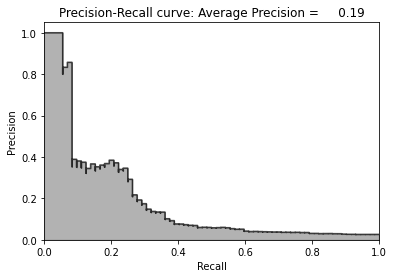

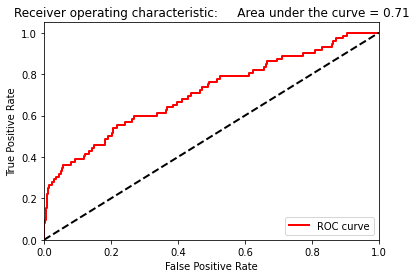

In [379]:
preds = plotResults(oc_test, anomalyScoresPCA, True)
# Tried 10, 20, 30, 110 pcs, 10 is the best

In [380]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)

In [381]:
preds.loc[preds["anomalyScore"] > 0.5, "predLabel"] = 1
preds.loc[preds["anomalyScore"] < 0.5, "predLabel"] = 0

97.48594111809462


,target,pred_counts
0,2951,3019
1,72,4


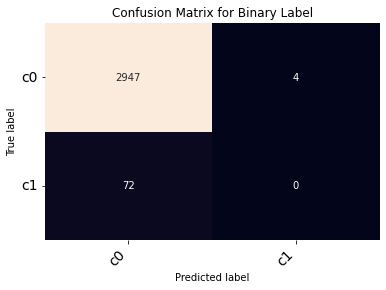

In [463]:
print(accuracy_score(oc_test, preds["predLabel"])*100)
class_count(oc_test, preds["predLabel"])
cm_single(oc_test, preds["predLabel"])

## LightGBM

In [533]:
X, y = data_treated.iloc[:,:-1], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)
y_traint = y_train.copy()
y_testt = y_test.copy()
y_train[y_train!=0] = 1
y_test[y_test!=0] = 1

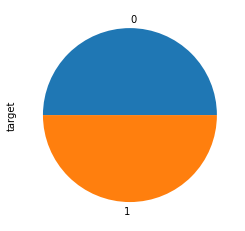

In [534]:
# Best Model 
# Perform transformation + outlier removed 
X_otrain, y_otrain = SMOTE().fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)

# filename = '../models/lgbm_v1.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))

In [397]:
lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_train, y_train)

# filename = '../models/lgbm_v2.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))

,target,pred_counts
0,2951,2990
1,72,33


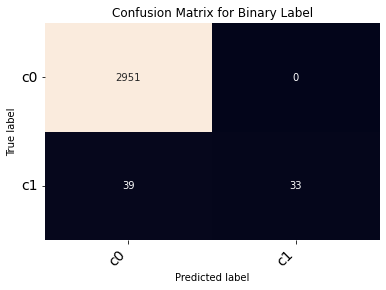

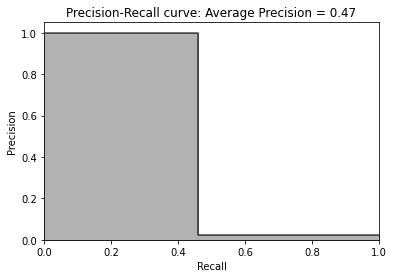

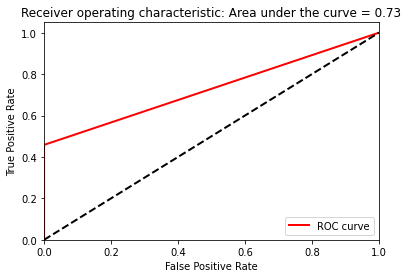

In [461]:
# Plots
filename = '../models/lgbm_v2.sav'
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
class_count(y_test, y_pred)
cm_single(y_test, y_pred)


precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
average_precision = average_precision_score(y_test,y_pred)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()


,target,pred_counts
0,2951,2979
1,72,44


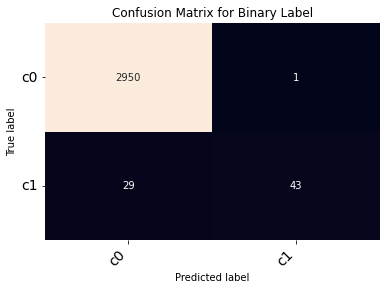

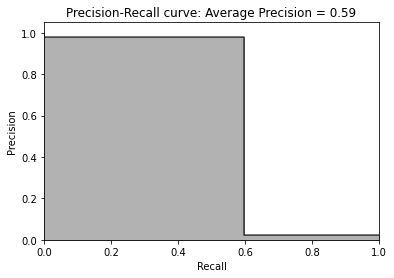

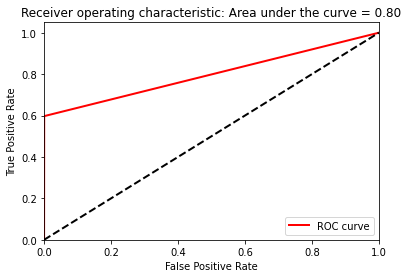

In [535]:
# Plots
filename = '../models/lgbm_v1.sav'
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
class_count(y_test, y_pred)
cm_single(y_test, y_pred)

precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
average_precision = average_precision_score(y_test,y_pred)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = \
{0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()


In [551]:
# Prepare data for stage 2
stage2_actualdf = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_testt, columns=['target']).reset_index(drop=True)], axis=1)
stage2_df = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_pred, columns=['pred'])], axis=1)
stage2_df.index = stage2_actualdf.index

In [557]:
# Check stage 2 data
stage2_df = stage2_actualdf.loc[stage2_df[stage2_df.pred==1].index]

In [621]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, random_state=123)
model.fit(stage2_df.loc[:, stage2_df.columns != "target"])
# filename = '../models/kmeans_v1.sav'
# pickle.dump(model, open(filename, 'wb'))

In [622]:
stage2_pred = model.labels_
print(np.unique(stage2_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4]), array([16,  2, 19,  3,  4], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([ 1, 13, 18,  8,  4], dtype=int64))


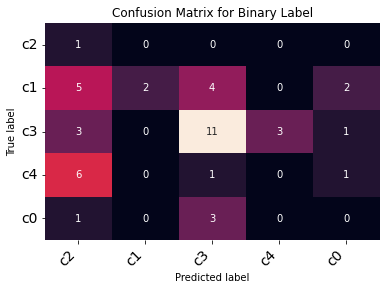

In [629]:
cm_single(y_test, stage2_pred)

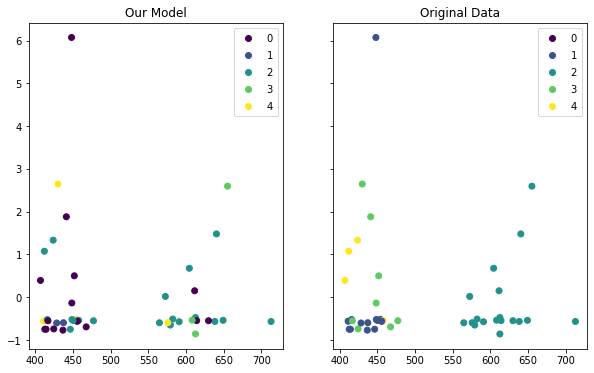

In [620]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
ax1.set_title('Our Model')
scatter1=ax1.scatter(stage2_df.iloc[:,9], stage2_df.iloc[:,10],c=model.labels_)
ax1.legend(*scatter1.legend_elements())
ax2.set_title('Original Data')
scatter2=ax2.scatter(stage2_df.iloc[:,9], stage2_df.iloc[:,10],c=stage2_df['target'])
ax2.legend(*scatter2.legend_elements())
